In [ ]:
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.document_loaders import TextLoader
from langchain.chains.question_answering import load_qa_chain
from langchain.output_parsers import RegexParser

## Setting the LLM

In [ ]:
with open("openai_api.txt", "r") as f:
    OPENAI_API = f.read()

llm = OpenAI(
    model_name = "gpt-3.5-turbo-instruct",
    openai_api_key = OPENAI_API
)

We can use different types of retrieving to answer a question from a Knowledge Base. Those are:
* `stuff`
* `map_reduce`
* `refine`
* `map_rerank`

For example:
```
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="map_reduce", retriever=docsearch.as_retriever())
```

```
from langchain.chains.question_answering import load_qa_chain
qa_chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")
qa = RetrievalQA(combine_documents_chain=qa_chain, retriever=docsearch.as_retriever())
```

In [ ]:
## Loading the Documents

loader = TextLoader("state_of_the_union.txt")
docs = loader.load()

## Setting rhe Query

query = "What did the president say about Justice Breyer"

### Stuff

The stuff documents chain is the most straightforward of the document chains. It takes a list of documents, inserts them all into a prompt and passes that prompt to an LLM.

This chain is well-suited for applications where documents are small and only a few are passed in for most calls.

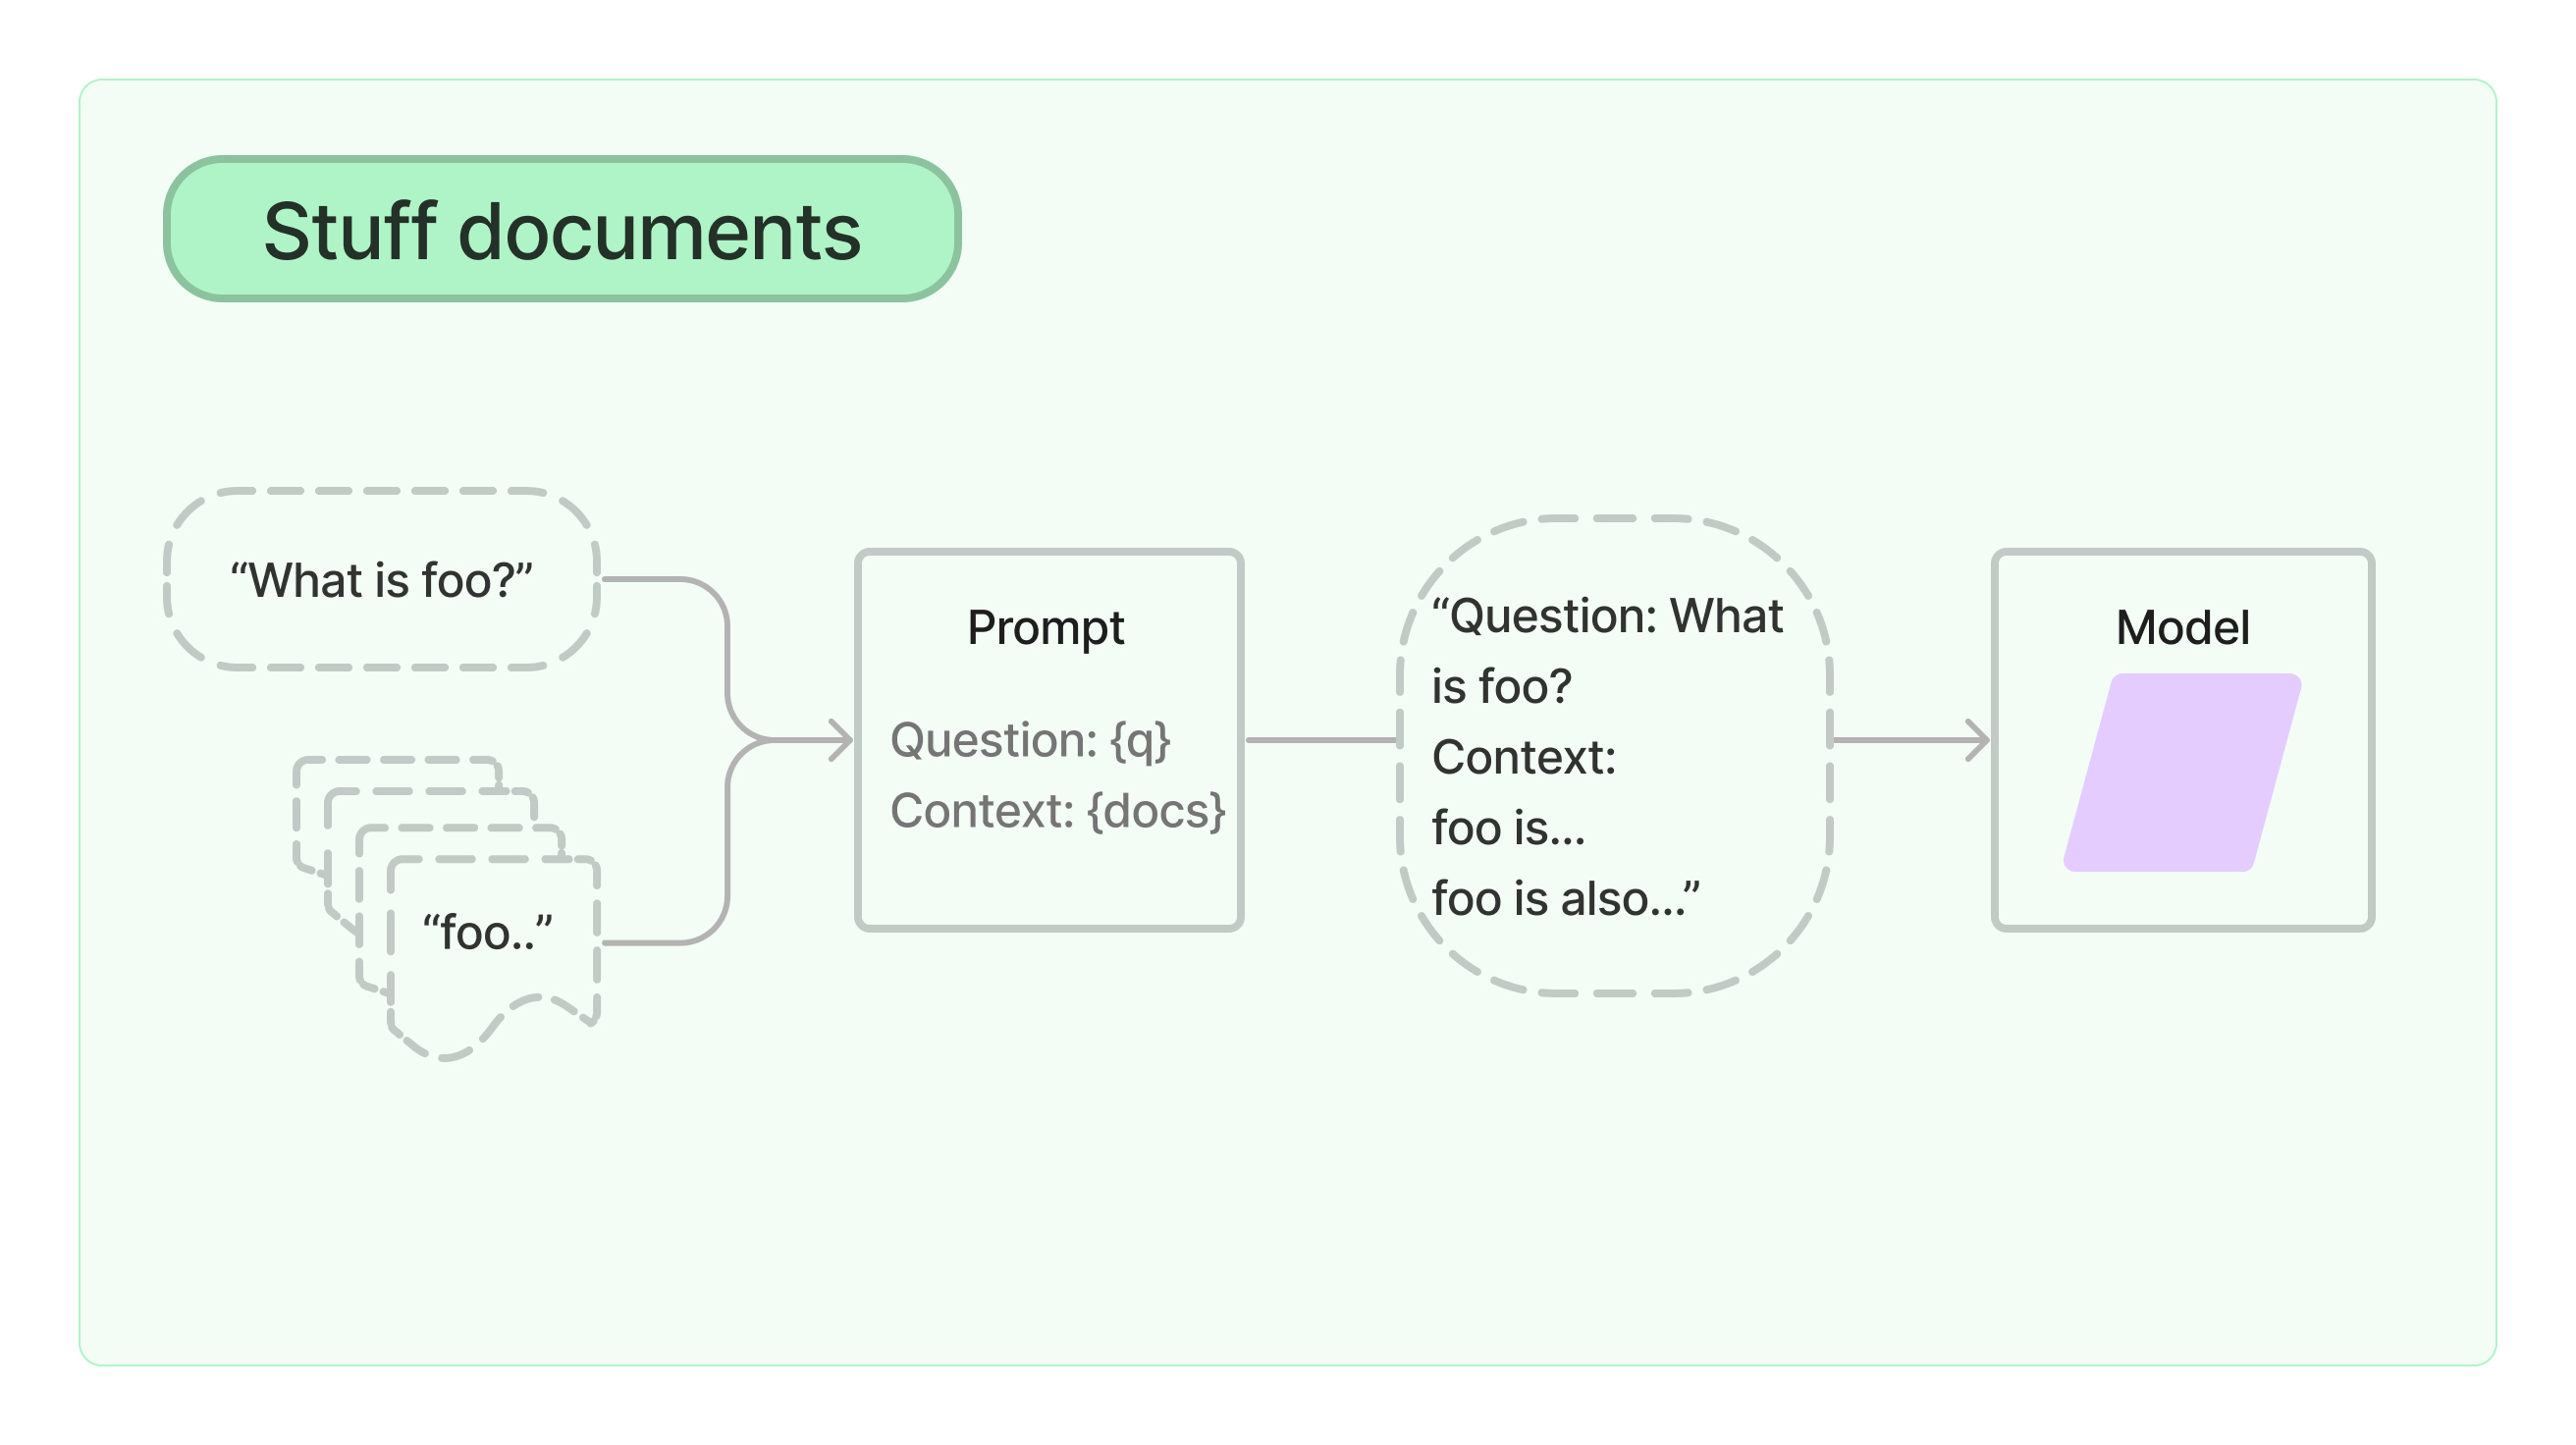

In [ ]:
chain = load_qa_chain(llm=llm, chain_type="stuff")

In [ ]:
## Customizing the `Stuff` Prompt

prompt_template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Answer in Italian:"""

PROMPT = PromptTemplate(
    template = prompt_template,
    input_variables = ["context", "question"]
)

chain = load_qa_chain(
    llm = llm,
    chain_type = "stuff",
    prompt = PROMPT
)

chain({"input_documents": docs, "question": query}, return_only_outputs=True)

### Refine

The Refine documents chain constructs a response by looping over the input documents and iteratively updating its answer. For each document, it passes all non-document inputs, the current document, and the latest intermediate answer to an LLM chain to get a new answer.

Since the Refine chain only passes a single document to the LLM at a time, it is well-suited for tasks that require analyzing more documents than can fit in the model's context. The obvious tradeoff is that this chain will make far more LLM calls than, for example, the Stuff documents chain. There are also certain tasks which are difficult to accomplish iteratively. For example, the Refine chain can perform poorly when documents frequently cross-reference one another or when a task requires detailed information from many documents

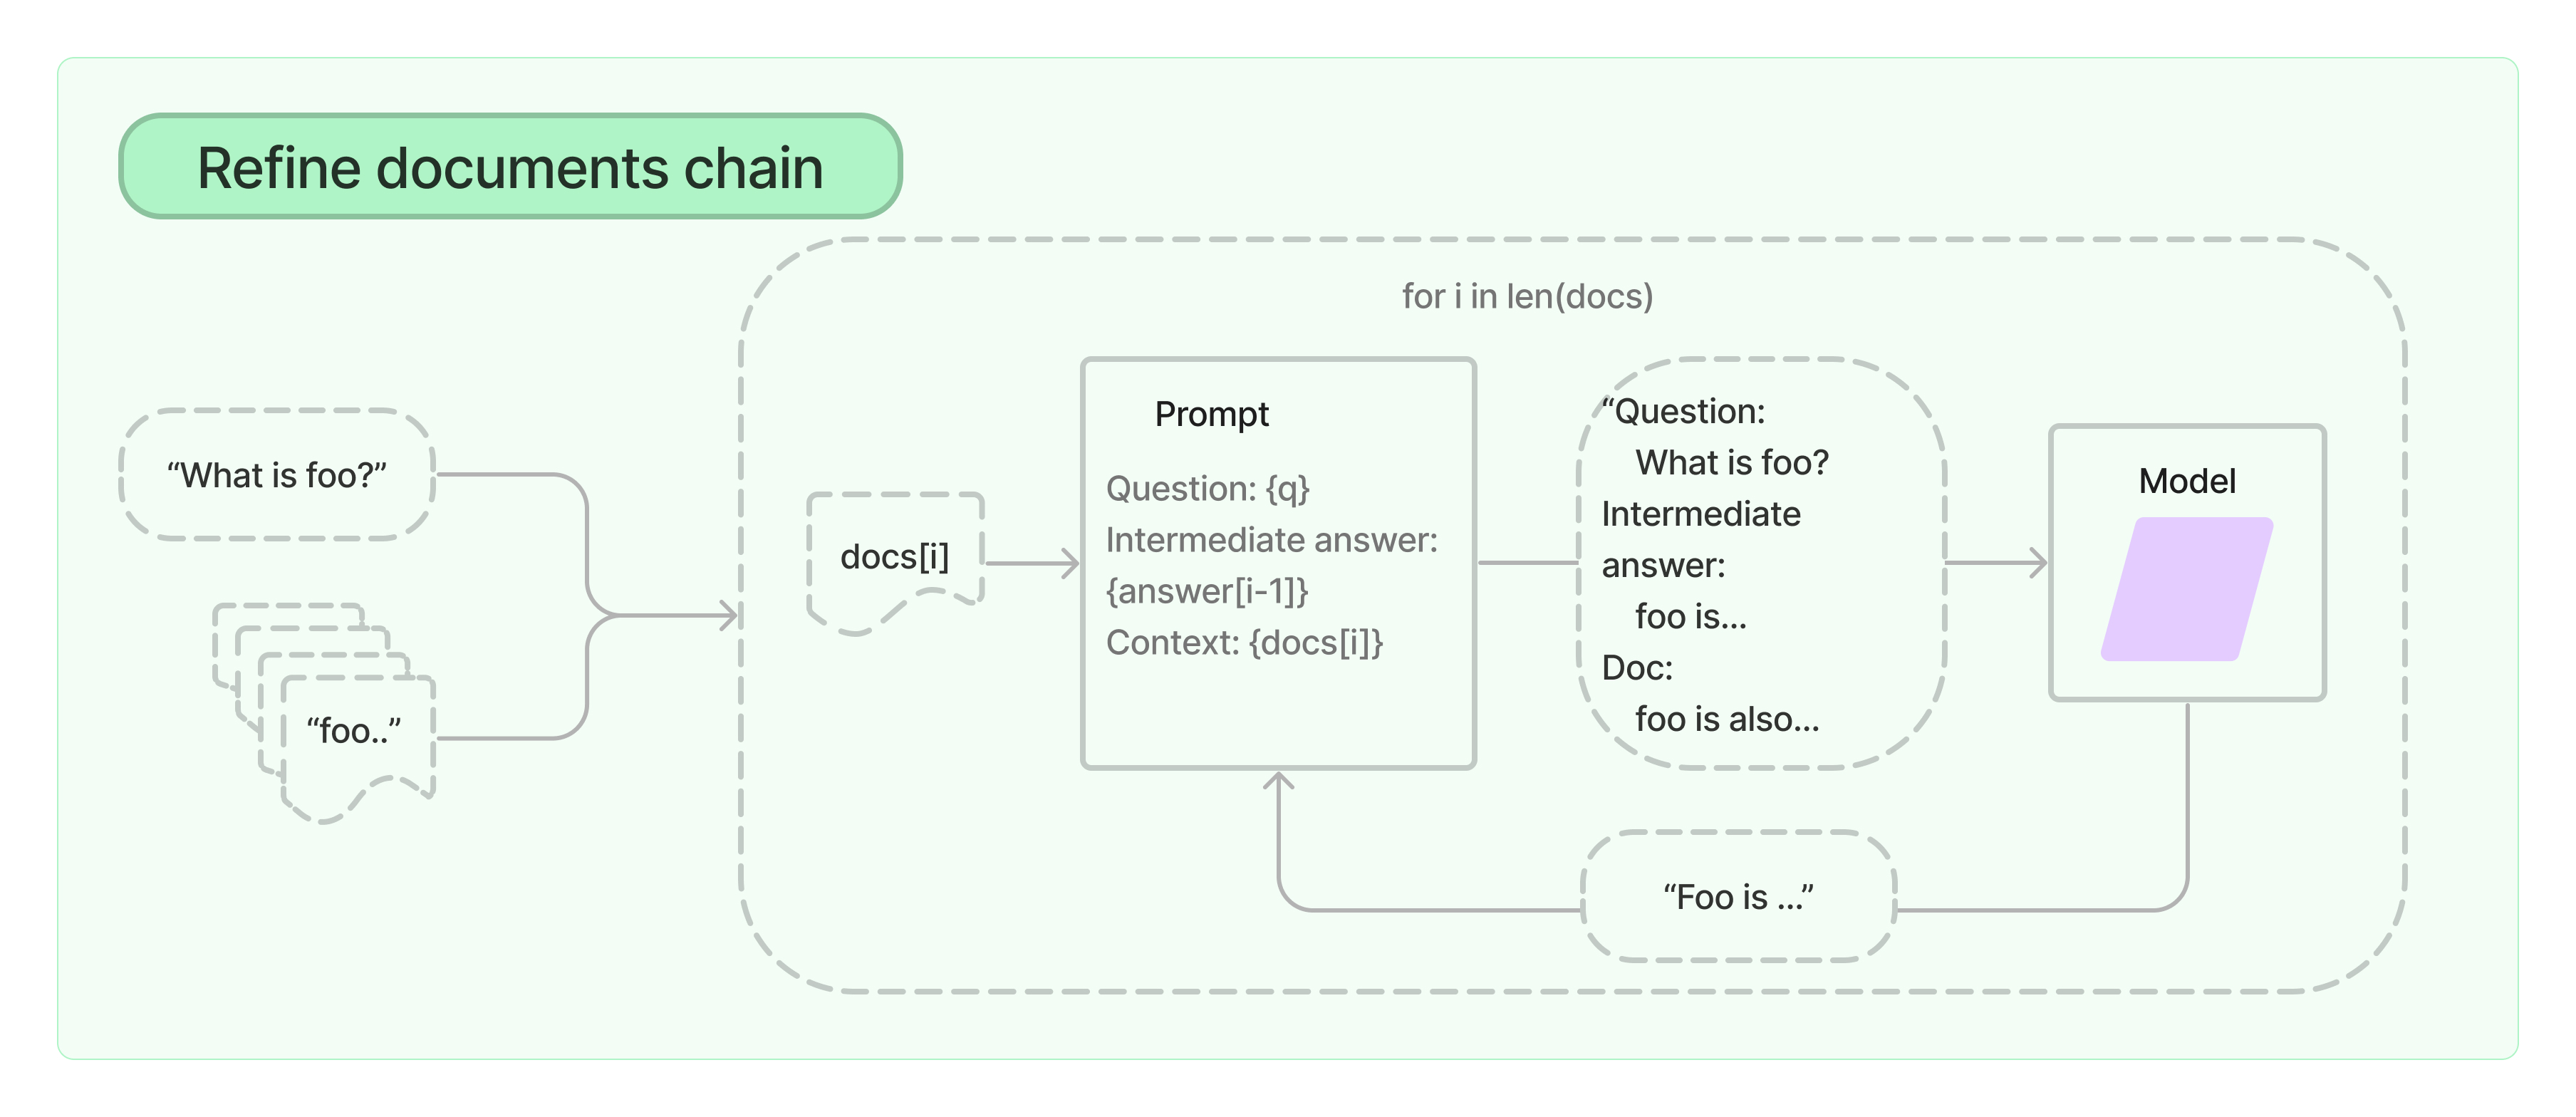

In [ ]:
chain = load_qa_chain(llm=llm, chain_type="refine")

chain = load_qa_chain(llm=llm, chain_type="refine", return_refine_steps=True)

In [ ]:
## Customizing the `Refine` Prompt

refine_prompt_template = (
    "The original question is as follows: {question}\n"
    "We have provided an existing answer: {existing_answer}\n"
    "We have the opportunity to refine the existing answer"
    "(only if needed) with some more context below.\n"
    "------------\n"
    "{context_str}\n"
    "------------\n"
    "Given the new context, refine the original answer to better "
    "answer the question. "
    "If the context isn't useful, return the original answer. Reply in Italian."
)
refine_prompt = PromptTemplate(
    input_variables=["question", "existing_answer", "context_str"],
    template=refine_prompt_template,
)

initial_qa_template = (
    "Context information is below. \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the question: {question}\nYour answer should be in Italian.\n"
)
initial_qa_prompt = PromptTemplate(
    input_variables=["context_str", "question"], template=initial_qa_template
)

chain = load_qa_chain(
    llm = llm,
    chain_type = "refine",
    return_refine_steps = True,
    question_prompt = initial_qa_prompt,
    refine_prompt = refine_prompt
)

chain({"input_documents": docs, "question": query}, return_only_outputs=True)

### Map Reduce

The map reduce documents chain first applies an LLM chain to each document individually (the Map step), treating the chain output as a new document. It then passes all the new documents to a separate combine documents chain to get a single output (the Reduce step). It can optionally first compress, or collapse, the mapped documents to make sure that they fit in the combine documents chain (which will often pass them to an LLM). This compression step is performed recursively if necessary.

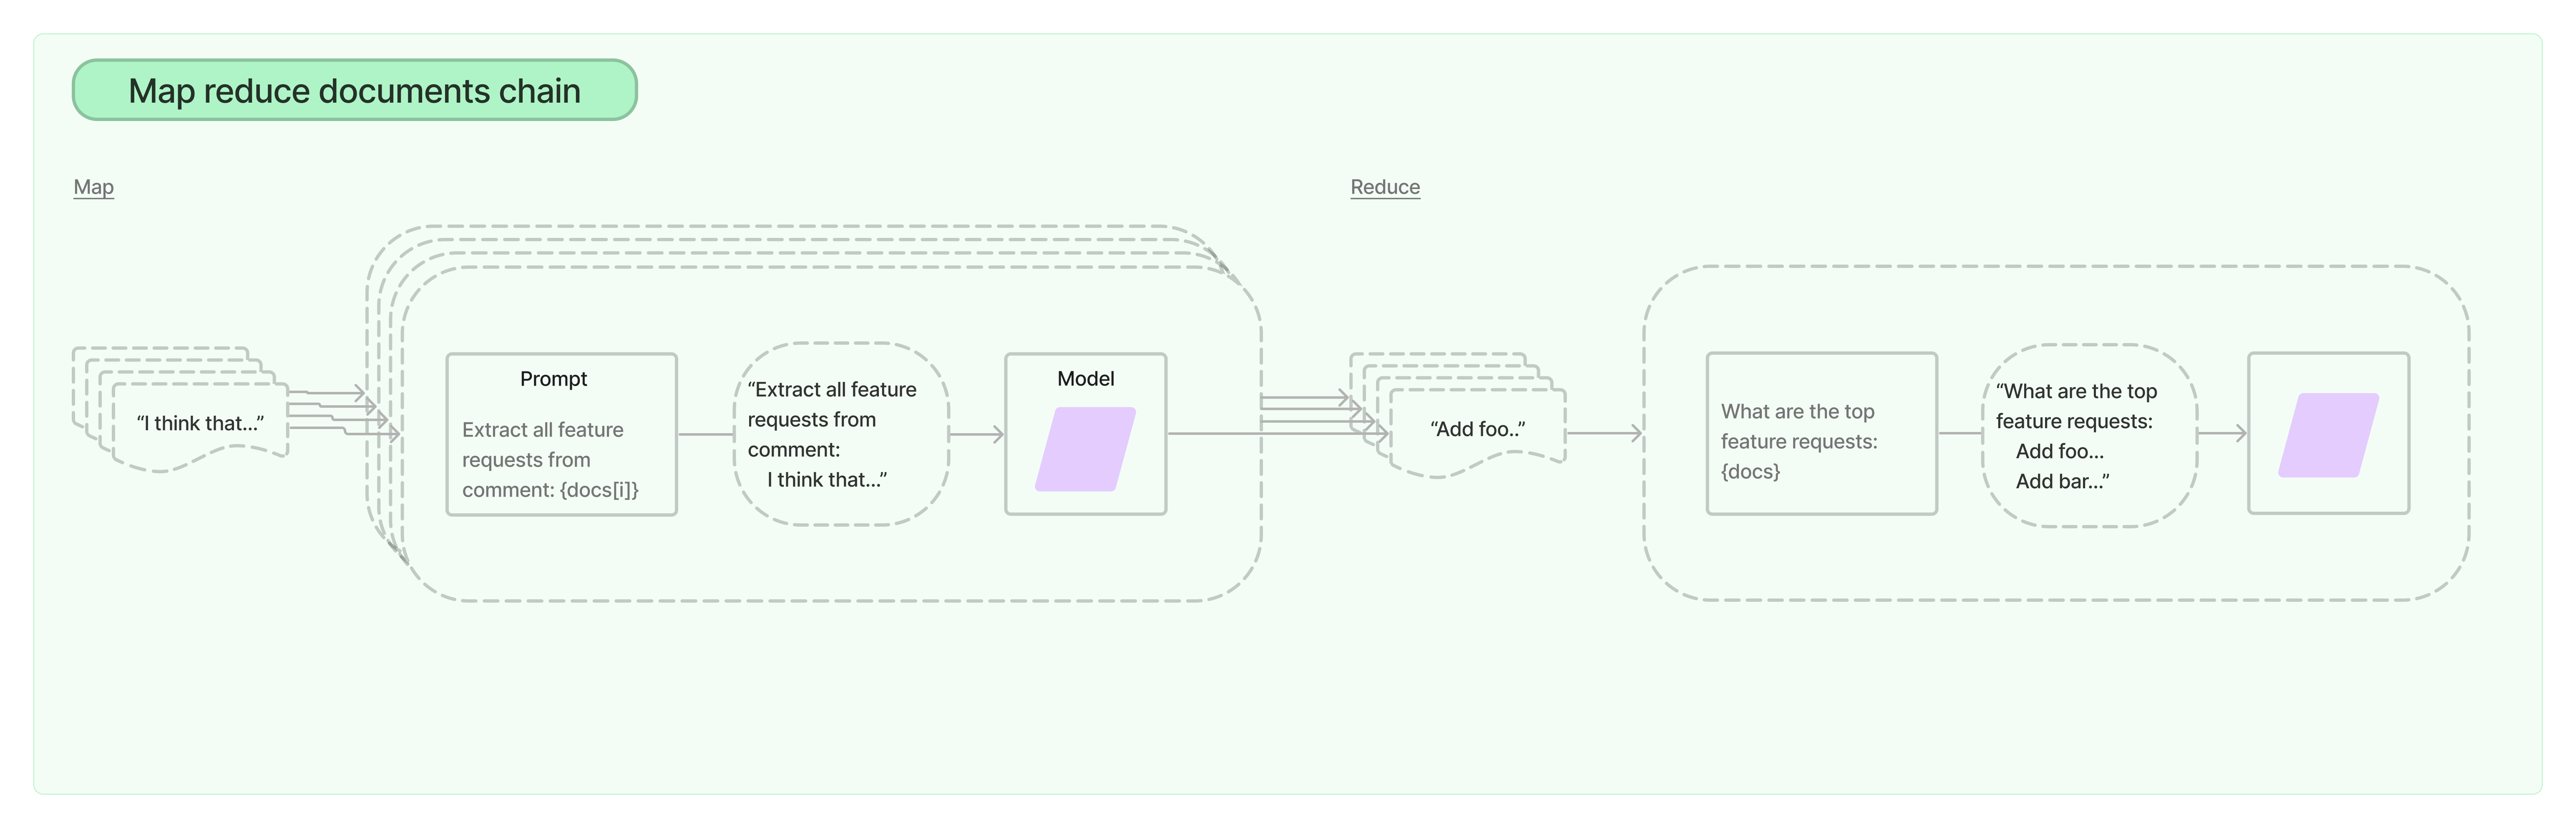

In [ ]:
chain = load_qa_chain(llm=llm, chain_type="map_reduce")

chain = load_qa_chain(llm=llm, chain_type="map_reduce", return_map_steps=True)

In [ ]:
## Customizing the `Map Reduce` Prompt

question_prompt_template = """Use the following portion of a long document to see if any of the text is relevant to answer the question.
Return any relevant text translated into italian.
{context}
Question: {question}
Relevant text, if any, in Italian:"""
QUESTION_PROMPT = PromptTemplate(
    template = question_prompt_template,
    input_variables = ["context", "question"]
)

combine_prompt_template = """Given the following extracted parts of a long document and a question, create a final answer italian.
If you don't know the answer, just say that you don't know. Don't try to make up an answer.

QUESTION: {question}
=========
{summaries}
=========
Answer in Italian:"""
COMBINE_PROMPT = PromptTemplate(
    template = combine_prompt_template,
    input_variables = ["summaries", "question"]
)

chain = load_qa_chain(
    llm = llm,
    chain_type = "map_reduce",
    return_map_steps = True,
    question_prompt = QUESTION_PROMPT,
    combine_prompt = COMBINE_PROMPT
)

chain({"input_documents": docs, "question": query}, return_only_outputs=True)

### Map Re-Rank

The map re-rank documents chain runs an initial prompt on each document, that not only tries to complete a task but also gives a score for how certain it is in its answer. The highest scoring response is returned.

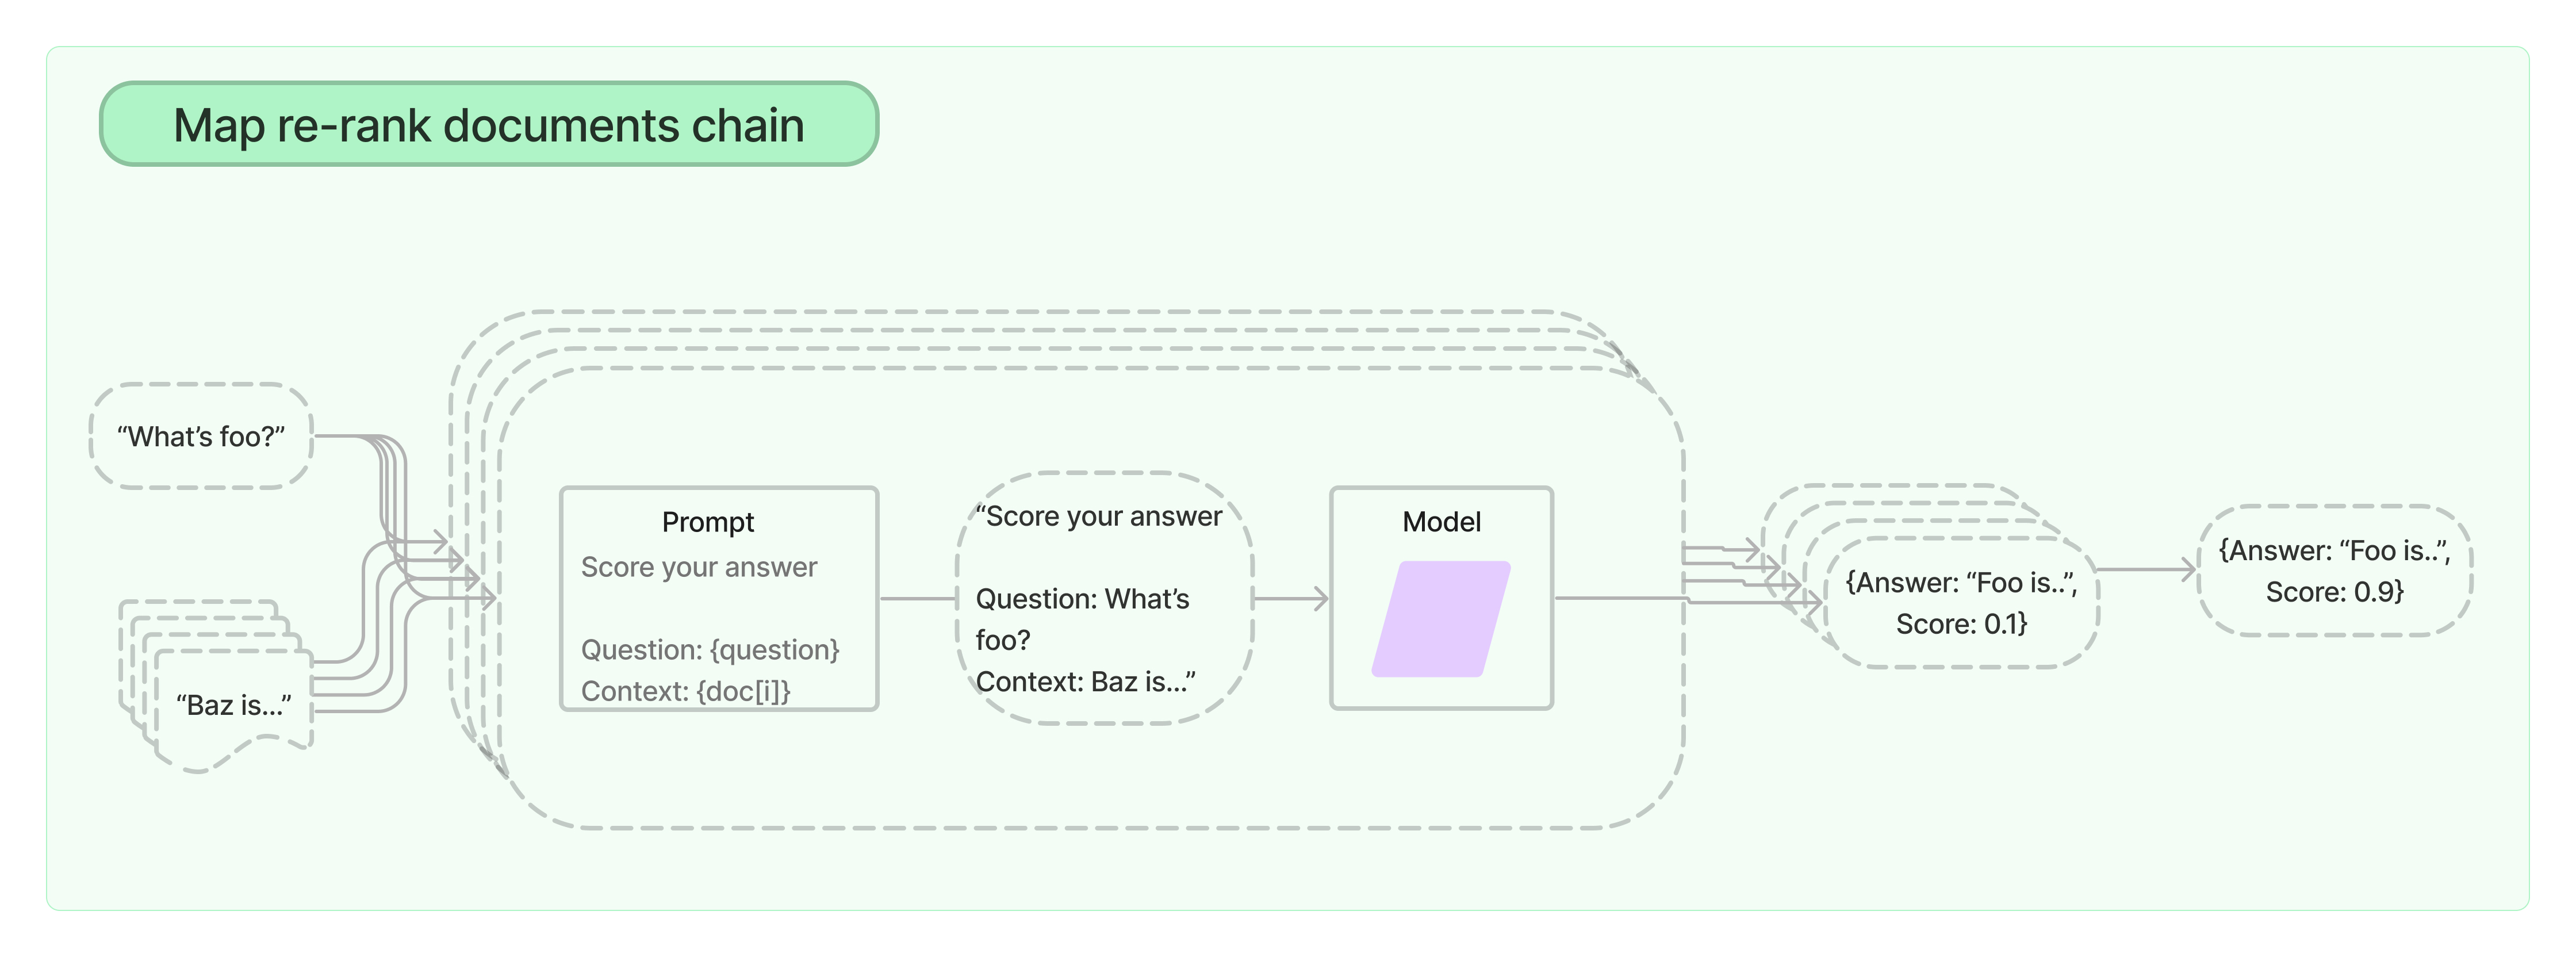

In [ ]:
chain = load_qa_chain(llm=llm, chain_type="map_rerank")

chain = load_qa_chain(llm=llm, chain_type="map_rerank", return_intermediate_steps=True)

In [ ]:
## Customize the `Map Re-Rank` Prompt

output_parser = RegexParser(
    regex=r"(.*?)\nScore: (.*)",
    output_keys=["answer", "score"],
)

prompt_template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

In addition to giving an answer, also return a score of how fully it answered the user's question. This should be in the following format:

Question: [question here]
Helpful Answer In Italian: [answer here]
Score: [score between 0 and 100]

Begin!

Context:
---------
{context}
---------
Question: {question}
Helpful Answer In Italian:"""
PROMPT = PromptTemplate(
    template = prompt_template,
    input_variables = ["context", "question"],
    output_parser = output_parser
)

chain = load_qa_chain(
    llm = llm,
    chain_type = "map_rerank",
    return_intermediate_steps = True,
    prompt = PROMPT
)

chain({"input_documents": docs, "question": query}, return_only_outputs=True)